## Прекод

Поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np

import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import wordnet

import re
import os
#from PIL import Image

from sklearn.model_selection import GroupShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from matplotlib import pyplot as plt

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
# скачивает данные
!wget -q https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip
!unzip -q dsplus_integrated_project_4.zip

In [3]:
#os.getcwd()

'/content'

In [4]:
DATA_PATH = '/content/to_upload' 

In [5]:
# выгрузим датасеты, и посмотрим что в них лежит 
df_train = pd.read_csv(os.path.join(DATA_PATH, 'train_dataset.csv'), 
                       names=['image_id', 'query_id', 'query_text'], 
                       header=0)

df_crowd_estimation = pd.read_csv(os.path.join(DATA_PATH, 'CrowdAnnotations.tsv'), 
                                  sep='\t', 
                                  names=['image_id', 'query_id', 'crowd_prob', 'count_positive', 'count_negative'])

df_expert_estimation = pd.read_csv(os.path.join(DATA_PATH, 'ExpertAnnotations.tsv'), 
                                   sep='\t',
                                   names=['image_id', 'query_id', 'exp_est_1', 'exp_est_2', 'exp_est_3'])

df_test = pd.read_csv(os.path.join(DATA_PATH, 'test_queries.csv'), 
                      sep='|', 
                      index_col=[0], 
                      names=['query_id', 'query_text', 'image_id'], 
                      header=0)
df_test = df_test[['image_id', 'query_id', 'query_text']]

## 0. Исследовательский анализ данных
Разберемся, что находится внутри нашего датасета и как с ними можно работать.

In [6]:
df_train.head(3)

,image_id,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...


In [7]:
# кол-во уникальных изображений
df_train['image_id'].describe()[:2]

count     5822
unique    1000
Name: image_id, dtype: object

In [8]:
# кол-во описаний на каждое изображение
df_train.groupby('image_id')['image_id'].count().describe()

count    1000.000000
mean        5.822000
std         1.583927
min         2.000000
25%         5.000000
50%         6.000000
75%         7.000000
max        10.000000
Name: image_id, dtype: float64

In [9]:
df_crowd_estimation.head(3)

,image_id,query_id,crowd_prob,count_positive,count_negative
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,0,3


In [10]:
df_crowd_estimation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   image_id        47830 non-null  object 
 1   query_id        47830 non-null  object 
 2   crowd_prob      47830 non-null  float64
 3   count_positive  47830 non-null  int64  
 4   count_negative  47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


In [11]:
df_expert_estimation.head(3)

,image_id,query_id,exp_est_1,exp_est_2,exp_est_3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2


In [12]:
df_expert_estimation.describe()

,exp_est_1,exp_est_2,exp_est_3
count,5822.000000,5822.000000,5822.000000
mean,1.436620,1.624356,1.881999
std,0.787084,0.856222,0.904087
min,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000
50%,1.000000,1.000000,2.000000
75%,2.000000,2.000000,2.000000
max,4.000000,4.000000,4.000000


In [13]:
df_test.head(3)

,image_id,query_id,query_text
0,1177994172_10d143cb8d.jpg,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an..."
1,1177994172_10d143cb8d.jpg,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .
2,1177994172_10d143cb8d.jpg,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water


In [14]:
df_test['image_id'].describe()[:2]

count     500
unique    100
Name: image_id, dtype: object

In [15]:
df_test.groupby('image_id')['image_id'].count().describe()

count    100.0
mean       5.0
std        0.0
min        5.0
25%        5.0
50%        5.0
75%        5.0
max        5.0
Name: image_id, dtype: float64

В нашем распоряжении 5822 тренировочных объектов и 500 тестовых. 

Данные из краудсорсинга содержат 47830 записей. Скорее всего, тут имеются дополнительные изображения или комментарии, которых нет в тренировочном датасете. 

In [16]:
# избавимся от лишних записей в датасете df_crowd_estimation
df_crowd_estimation = df_crowd_estimation.merge(df_train[['image_id', 'query_id']], on=['image_id', 'query_id'])
df_crowd_estimation['crowd_prob'].describe()

count    2329.000000
mean        0.198283
std         0.343315
min         0.000000
25%         0.000000
50%         0.000000
75%         0.333333
max         1.000000
Name: crowd_prob, dtype: float64

In [17]:
# распределение кол-ва оценщиков на краудсорсинге
(df_crowd_estimation['count_positive'] + df_crowd_estimation['count_negative']).value_counts()

3    2266
4      45
5      13
6       5
dtype: int64

Удалось в несколько раз сократить кол-во записей в датасете df_crowd_estimation. Мы получили 2329 объекта. Это значит, что не для всех тренировочных объектов были даны оценки на краудсорсинге. 

In [18]:
# смотрим как взаимосвязаны df_train и df_expert_estimation
df_expert_estimation = df_expert_estimation.merge(df_train[['image_id', 'query_id']], on=['image_id', 'query_id'])
df_expert_estimation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   image_id   5822 non-null   object
 1   query_id   5822 non-null   object
 2   exp_est_1  5822 non-null   int64 
 3   exp_est_2  5822 non-null   int64 
 4   exp_est_3  5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 272.9+ KB


А вот оценки среди экспертов полностью соответсвуют тренировочным объектам.

Покажем на первых десяти изображений их соответствующее описание из тренировочного и тестого датасета.

A young boy , playing basketball , is getting ready to take a shot .


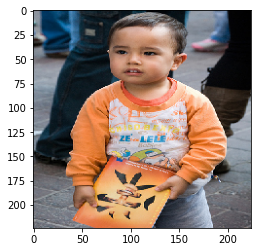

A rock climber climbs in between two very large rocks .


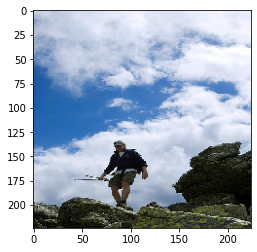

A man in a white shirt and helmet is using climbing equipment .


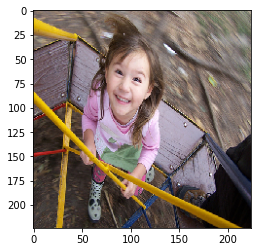

A man in a suit dances with a young girl in front of an audience .


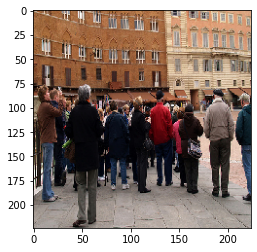

A group of men are playing rugby .


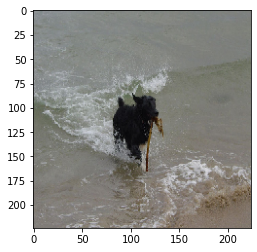

In [19]:
# df_train
df_sample = df_train.sample(5, random_state=23)
for i in range(df_sample.shape[0]):
  print(df_sample['query_text'].iloc[i])
  path = os.path.join(DATA_PATH, 'train_images/', df_sample['image_id'].iloc[i])
  plt.imshow(image.load_img(path, target_size=(224, 224)))
  plt.show()

The child in the blue shorts dribbled the basketball .


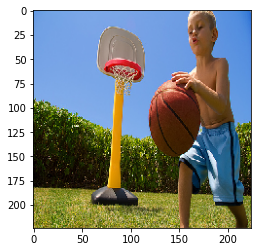

Two black dogs are fighting over a toy


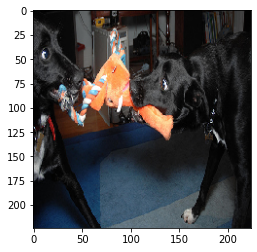

A cyclist riding on their front wheel on the asphalt .


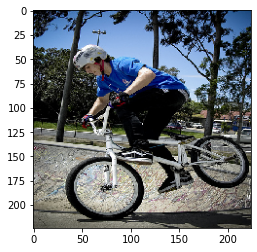

A group of people walk through a shopping mall .


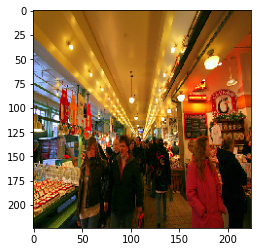

The man is performing a trick with an orange bicycle .


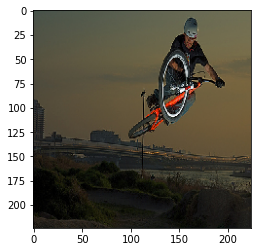

In [20]:
# df_test
df_sample = df_test.sample(5, random_state=23)
for i in range(df_sample.shape[0]):
  print(df_sample['query_text'].iloc[i])
  path = os.path.join(DATA_PATH, 'test_images/', df_sample['image_id'].iloc[i])
  plt.imshow(image.load_img(path, target_size=(224, 224)))
  plt.show()

В тестовом датасете из 5 случайных фото, описание и изображение сходятся.
А в тренировочном, наоборот, большинство не сошлось.


Из анализа можно сделать следующие выводы:
- В нашем тренировочном датасете более 5000 записей, из которых 1000 уникальных изображений, в тестовом - 500 записей и 100 уникальных изображений;
- В тестовой части имеются описания и изображения, которые полностью соответсвуют друг другу, а в тренировочной, наоборот, наблюдаются противоречия;
- На каждое изображение в тренировочном датасете приходится от 2 до 10 описаний, в тестовом - только 5. 
- Привели в порядок датасеты с оценками;
- В основном, эксперты ставили оценку - 2 из 4, а из краудсорсинга - 0.

## 1. Обработка оценок

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи нужно эти оценки агрегировать — превратить в одну. 

Создадим и применим свой метод агрегации оценок.

После анализа экспертных и краудсорсинговых оценок объединим их в одну по критерию: оценка эксперта присвоим с коэффициентом 0.8, а крауда — с коэффициентом 0.2.

Модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.

Сначала найдем вреоятность сходства изображения-запроса по экспертной оценке.

Минимальная оценка равна 1, а максималная - 4. Чтобы вероятность самой низкой оценки была равна нулю, обновим оценки. Минимальную приравняем к 0, а масимальную - 3. Потом посчитаем вероятность как отношение суммы оценки трех экспертов на макисмально возможную оценку среди экспертов (которая равна 9).

In [21]:
df_expert_estimation[['exp_est_1', 'exp_est_2', 'exp_est_3']] = df_expert_estimation[['exp_est_1', 'exp_est_2', 'exp_est_3']] - 1
df_expert_estimation['exp_prob'] = (df_expert_estimation['exp_est_1'] + df_expert_estimation['exp_est_2'] + df_expert_estimation['exp_est_3'])/9

df_expert_estimation.head(3)

,image_id,query_id,exp_est_1,exp_est_2,exp_est_3,exp_prob
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,0,0,0,0.000000
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,0,0,1,0.111111
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,0,0,1,0.111111


В таблице `df_crowd_estimation` уже посчитана доля людей, подтвердивших, что описание соответствует изображению (колонка `coef`). Возмем ее, как вероятность сходства изображения-запроса по оценке, полученной из краудсорсинга.

Добавим обе оценки в таблицу `df_train`, а затем объединим их. Для этого найдем средневзвешенное значение, у которого вес экспертной оценки `0.8`, а у краудсорсинговой - `0.2`.

In [22]:
# добавляем временные столбцы exp_prob и crowd_prob в датасет df_train
df_train = df_train.merge(df_expert_estimation, on=['image_id', 'query_id'], how='inner')
df_train = df_train.merge(df_crowd_estimation, on=['image_id', 'query_id'], how='left')
df_train.head(3)

,image_id,query_id,query_text,exp_est_1,exp_est_2,exp_est_3,exp_prob,crowd_prob,count_positive,count_negative
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0,0,0,0.000000,0.0,0.0,3.0
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0,0,0,0.000000,NaN,NaN,NaN
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0,1,1,0.222222,0.0,0.0,3.0


In [23]:
# находим итоговую оценку
df_train['probability'] = df_train['exp_prob']*0.8 + df_train['crowd_prob']*0.2
df_train['probability'] = df_train['probability'].fillna(df_train['exp_prob'])
df_train.head(3)

,image_id,query_id,query_text,exp_est_1,exp_est_2,exp_est_3,exp_prob,crowd_prob,count_positive,count_negative,probability
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0,0,0,0.000000,0.0,0.0,3.0,0.000000
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0,0,0,0.000000,NaN,NaN,NaN,0.000000
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0,1,1,0.222222,0.0,0.0,3.0,0.177778


## 2. Проверка данных

В некоторых странах, где работает наша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В нашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
> 

Однако у нас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

Чтобы выявить, присутсвует ли на фото лица младше 16 лет, поступим так:

- проведем токонезацию текста, исключим слова-паразиты, присвоим тег к каждому слову и лемматизируем их;
- по комментариям отберем те фото, которые содержат ключевые слова (такие как 'boy', 'girl', 'young' и т.д.);
- установим вероятность сходства фото к описанию (если сходство выше значения 25%, то такие фото лучше исключить из датасета);
- очистим из датасета все записи, в которых содержатся отобранные фото.

Но есть нюансы. Мы полагаем, что в описании должно содержаться ключевое слово. Если его нет, то возникает возможность не заблокировать изображение с ребенком.

Допустим, взять изображение, в котором содержится кот, дом, мать и мальчик. Если среди всех описаний к этому изображению не будет хотя бы одно, в котором указано, что пристутствует мальчик, то модерация пропустит это фото.

Может случиться и так, что в описание некорректно было указано ключевое слово. Например, изображение с котом, домом, женой и мужем. Если в описании к этому изображению будет упомянут ребенок, то модерация исключит данное фото.

P.S. Если есть способ как-то это избежать, то я с радостью его рассмотрю :)

In [24]:
# слова-паразиты
stopwords = set(nltk_stopwords.words('english'))
stopwords

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [25]:
#text = 'I can hardly answer that question'
#nltk.pos_tag(nltk.word_tokenize(text))

In [26]:
#text = '''The teacher didn't like my answer'''
#nltk.pos_tag(nltk.word_tokenize(text))

In [27]:
'''POS-тег'''
def get_wordnet_pos(tag):
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag[0], wordnet.NOUN)

'''Токенизация и лемматизация'''
def lemmatize(text):
    text = nltk.pos_tag(nltk.word_tokenize(text, language = "english"))
    l = nltk.WordNetLemmatizer()
    lemm_list = [l.lemmatize(word, get_wordnet_pos(tag)) for word, tag in text if word not in stopwords]
    lemm_text = " ".join(lemm_list) 
    return lemm_text

'''Очистка текста от неалфавитных символов и приведение к нижнему регистру'''
def clear_text(text):
    rs = re.sub(r'[^a-zA-Z]', ' ', text.lower())
    return ' '.join(rs.split())

In [28]:
# проверка
print(df_train['query_text'][5817])
print(lemmatize(clear_text(df_train['query_text'][5817])))

A man in an ampitheater talking to a boy .
man ampitheater talk boy


In [29]:
%%time
# применяем чистку и лемматезируем 
df_train['query_text_lemma'] = df_train['query_text'].apply(clear_text).apply(lemmatize)
df_test['query_text_lemma'] = df_train['query_text'].apply(clear_text).apply(lemmatize)

CPU times: user 12.6 s, sys: 281 ms, total: 12.9 s
Wall time: 19.3 s


In [30]:
df_train.head(3)

,image_id,query_id,query_text,exp_est_1,exp_est_2,exp_est_3,exp_prob,crowd_prob,count_positive,count_negative,probability,query_text_lemma
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0,0,0,0.000000,0.0,0.0,3.0,0.000000,young child wear blue goggles sit float pool
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0,0,0,0.000000,NaN,NaN,NaN,0.000000,young child wear blue goggles sit float pool
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0,1,1,0.222222,0.0,0.0,3.0,0.177778,young child wear blue goggles sit float pool


In [31]:
df_test.head(3)

,image_id,query_id,query_text,query_text_lemma
0,1177994172_10d143cb8d.jpg,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",young child wear blue goggles sit float pool
1,1177994172_10d143cb8d.jpg,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,young child wear blue goggles sit float pool
2,1177994172_10d143cb8d.jpg,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,young child wear blue goggles sit float pool


In [32]:
# стоп-слова, в которых содержатся возврастные ограничения
child_stopwords = [
    "boy",
    "girl",
    "child",
    "baby",
    "kid",
    "babe",
    "infant",
    "teenager",
    "teeny",
    "juvenile",
    "teener",
    "stripling",
]

In [33]:
# создаем функцию для проверки каждого текста в датасете 
def child_identify(row):
    for w in child_stopwords:
        if w in row:
            return True
    return False    

In [34]:
df_train['child_identify'] = df_train['query_text_lemma'].apply(child_identify)
df_test['child_identify'] = df_test['query_text_lemma'].apply(child_identify)
df_train.head(3)

,image_id,query_id,query_text,exp_est_1,exp_est_2,exp_est_3,exp_prob,crowd_prob,count_positive,count_negative,probability,query_text_lemma,child_identify
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0,0,0,0.000000,0.0,0.0,3.0,0.000000,young child wear blue goggles sit float pool,True
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0,0,0,0.000000,NaN,NaN,NaN,0.000000,young child wear blue goggles sit float pool,True
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0,1,1,0.222222,0.0,0.0,3.0,0.177778,young child wear blue goggles sit float pool,True


In [35]:
# оценим сколько уникальных изображений у нас было, и сколько стало после преобразований
df_train['image_id'].describe()[:2]

count     5822
unique    1000
Name: image_id, dtype: object

In [36]:
# кол-во уникальных изображений, в которых содержатся дети с вероятностью выше 25% по мнению экспертов и толпы
# при условии что комментарии обязательно должны включать ключевые слова, если на фото есть дети
image_id_train_listdel = df_train[(df_train['child_identify']) & (df_train['probability'] > 0.25)]['image_id'].unique()
len(image_id_train_listdel)

255

In [37]:
# ощищаем тренировочный датасет
df_train = df_train[~df_train['image_id'].isin(image_id_train_listdel)]
df_train['image_id'].describe()[:2]

count     4245
unique     745
Name: image_id, dtype: object

У тестового набора данных остутствует показатель вероятности. Поэтому мы его опустим и удалим все изображение, в которых было упомянуто хотя бы одно ключевое слово.

In [38]:
df_test['image_id'].describe()[:2]

count     500
unique    100
Name: image_id, dtype: object

In [39]:
image_id_test_listdel = df_test[df_test['child_identify']]['image_id'].unique()
len(image_id_test_listdel)

34

In [40]:
# ощищаем тестовый датасет
#df_test = df_test[~df_test['image_id'].isin(image_id_test_listdel)]
#df_test['image_id'].describe()[:2]

После модераций всех изображений и описаний, мы сократили тренировочную выборку на 27%.

## 3. Разбивка тренировочного датасета на обучающую и валидационную выборки
Прежде чем векторизовать набор описаний, отделим валидационную выборку: её не следует использовать при ембеддинге. 

Поскольку у нас одному изображению соответствует несколько описаний, при разбивки на выборки важно учесть, чтобы изображения и их комментарии были в одной группе. Будет не правильно, если одно и тоже изображение окажется и в тренировочной и в валидационной выборках.

In [41]:
# чтобы решить эту задачу воспользуемся методом GroupShuffleSplit из библиотеки sklearn
gss = GroupShuffleSplit(n_splits=3, train_size=0.75, random_state=42)
for i, (train_index, valid_index) in enumerate(gss.split(X=df_train.drop(columns=["probability"]),
                                                        y=df_train["probability"],
                                                        groups=df_train["image_id"],
                                                        )):
    X_train, X_valid = df_train.iloc[train_index], df_train.iloc[valid_index]

In [42]:
X_train.head(3)

,image_id,query_id,query_text,exp_est_1,exp_est_2,exp_est_3,exp_prob,crowd_prob,count_positive,count_negative,probability,query_text_lemma,child_identify
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0,0,0,0.0,0.0,0.0,3.0,0.0,young child wear blue goggles sit float pool,True
6,3155451946_c0862c70cb.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0,0,0,0.0,NaN,NaN,NaN,0.0,young child wear blue goggles sit float pool,True
8,343218198_1ca90e0734.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0,0,0,0.0,NaN,NaN,NaN,0.0,young child wear blue goggles sit float pool,True


In [43]:
# оставим в полученных датасетах только необходимые столбцы
X_train = X_train[['image_id', 'query_text_lemma', 'probability']]
X_valid = X_valid[['image_id', 'query_text_lemma', 'probability']]

In [44]:
X_train.shape

(3202, 3)

## 4. Векторизация описаний

Векторезируем и дадим оценку важности слова с помощью TF-IDF. 

TF отвечает за количество упоминаний слова в отдельном тексте, а IDF отражает частоту его употребления во всём корпусе

In [45]:
# TF-IDF
tf_idf_short = TfidfVectorizer(stop_words="english") #, ngram_range=(1, 2)) 
tf_idf_short.fit(X_train['query_text_lemma']) 

tf_idf_short_train = tf_idf_short.transform(X_train['query_text_lemma']) 
tf_idf_short_valid = tf_idf_short.transform(X_valid['query_text_lemma']) 
tf_idf_short_test = tf_idf_short.transform(df_test['query_text_lemma']) 

In [46]:
tf_idf_short_train.shape

(3202, 1085)

Мы получили 1085 новых признаков. Можно попробовать увеличить N-грамму до 2 слов, чтобы повысить качество предсказаний, так как в нашем арсенале не так много записей для обучения модели.

In [47]:
# TF-IDF
tf_idf_long = TfidfVectorizer(stop_words="english", ngram_range=(1, 2)) 
tf_idf_long.fit(X_train['query_text_lemma']) 

tf_idf_long_train = tf_idf_long.transform(X_train['query_text_lemma']) 
tf_idf_long_valid = tf_idf_long.transform(X_valid['query_text_lemma']) 
tf_idf_long_test = tf_idf_long.transform(df_test['query_text_lemma']) 

In [48]:
tf_idf_long_train.shape

(3202, 4263)

In [49]:
tf_idf_long_valid.shape

(1043, 4263)

In [50]:
tf_idf_long_test.shape

(500, 4263)

Получилось 4263 признаков. Слишком много параметров, оставим первый вариант.


In [51]:
tf_idf = tf_idf_short

tf_idf_train = tf_idf_short_train
tf_idf_valid = tf_idf_short_valid
tf_idf_test = tf_idf_short_test

## 5. Векторизация изображений

Векторизируем изображения с использованием модели ResNet50 из библиотеки Keras.

Нам понадобится проделать следующее:
- Загрузить изображения, и привести их к формату, на котором обучена нейросет ResNet50 (224, 224, 3);
- На выходе ResNet50 предопределить слой, чтобы на выходе мы получили вектор изображения.

In [52]:
def create_model(input_shape):
    optimizer = Adam(learning_rate=0.0001)
    cnn = ResNet50(input_shape=input_shape, include_top=False, weights="imagenet")

    model = Sequential()
    model.add(cnn)
    model.add(GlobalAveragePooling2D())
    model.compile(loss="mean_absolute_error", optimizer=optimizer, metrics=["mae"])

    return model

In [53]:
def image_to_array(path: str, wh: int = 224, ht: int = 224):
    img = image.load_img(path, target_size=(wh, ht))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0) # преобразуем вектор с размерами (224, 224, 3) к (1, 224, 224, 3), где 1 обозначет кол-во рассматриваемых объектов
    x = preprocess_input(x) # preprocess_input преобразует исходную матрицу к необходимому виду для предобученной модели Resnet50
    return x

In [54]:
model = create_model((224, 224, 3))

94765736/94765736 [==============================] - 0s 0us/step


In [55]:
%%time
v_dict = {}
for el in X_train['image_id'].unique():
  path = os.path.join(DATA_PATH, 'train_images/', el)
  v = image_to_array(path)
  v = model(v)
  v_dict[el] = v.numpy()[0]

CPU times: user 38.9 s, sys: 1.01 s, total: 39.9 s
Wall time: 48.3 s


In [56]:
df_image_train = pd.DataFrame(v_dict.items(), columns=['image_id', 'image_vector'])
df_image_train.head(3)

,image_id,image_vector
0,1056338697_4f7d7ce270.jpg,"[0.086642206, 0.0011715014, 0.0, 2.470206, 0.0..."
1,3155451946_c0862c70cb.jpg,"[0.08265893, 1.5919135, 0.14580011, 2.6117811,..."
2,343218198_1ca90e0734.jpg,"[0.25175574, 0.7176523, 0.06834249, 0.53177565..."


In [57]:
df_image_train['image_vector'][0].shape

(2048,)

На выходе мы имеем 2048 признаков. Аналогично векторизуем изображения в валидационном и тренировочном датасетах.

In [58]:
# по аналогии векторизуем изображения в валидационном датасете
%%time
v_dict = {}
for el in X_valid['image_id'].unique():
  path = os.path.join(DATA_PATH, 'train_images/', el)
  v = image_to_array(path)
  v = model(v)
  v_dict[el] = v.numpy()[0]

CPU times: user 11.7 s, sys: 74.4 ms, total: 11.7 s
Wall time: 11.7 s


In [59]:
df_image_valid = pd.DataFrame(v_dict.items(), columns=['image_id', 'image_vector'])

In [60]:
df_image_valid['image_vector'][0].shape

(2048,)

In [61]:
# и в тестовом датасете
%%time
v_dict = {}
for el in df_test['image_id'].unique():
  path = os.path.join(DATA_PATH, 'test_images/', el)
  v = image_to_array(path)
  v = model(v)
  v_dict[el] = v.numpy()[0]

CPU times: user 6.82 s, sys: 58 ms, total: 6.88 s
Wall time: 7.04 s


In [62]:
df_image_test = pd.DataFrame(v_dict.items(), columns=['image_id', 'image_vector'])

In [63]:
df_image_test['image_vector'][0].shape

(2048,)

## 6. Объединение векторов
В нашем распоряжении два вектора. Вектор описания с 1085 признаками и вектор изображений с 2048 (суммарно мы имеем 3133). 

Наши вектора расположены в одной колонки. Чтобы модель учитывала их всех, нужно разбить их по отдельности. В конечном счете, у нас должно получиться 3133 столбцов.

In [64]:
# преобразрования для вектора описаний в тренировочном датасете
df_tf_idf_train = pd.DataFrame(tf_idf_train.toarray())
df_tf_idf_train.head(3)

,0,1,2,3,4,5,6,7,8,9,...,1075,1076,1077,1078,1079,1080,1081,1082,1083,1084
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.282191,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.282191,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.282191,0.0


In [65]:
# в valid и test
df_tf_idf_valid = pd.DataFrame(tf_idf_valid.toarray())
df_tf_idf_test = pd.DataFrame(tf_idf_test.toarray())

In [66]:
# преобразрования для вектора изображений в тренировочном датасете
l = []
for el in df_image_train['image_vector']:
  l.append(el)
df_image_train_update = pd.concat([df_image_train, pd.DataFrame(l)], axis=1) #.drop(columns='image_vector')
df_image_train_update.head(3)
X_train_update = X_train.merge(df_image_train_update.drop(columns='image_vector'), on=['image_id'])
X_train_update.head(3)

,image_id,query_text_lemma,probability,0,1,2,3,4,5,6,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,1056338697_4f7d7ce270.jpg,young child wear blue goggles sit float pool,0.000000,0.086642,0.001172,0.0,2.470206,0.017124,0.0,0.323182,...,0.582473,0.487889,1.598633,0.436897,0.720545,0.062267,0.545402,0.021593,1.07483,0.103507
1,1056338697_4f7d7ce270.jpg,girl wear yellow shirt sunglass smile,0.088889,0.086642,0.001172,0.0,2.470206,0.017124,0.0,0.323182,...,0.582473,0.487889,1.598633,0.436897,0.720545,0.062267,0.545402,0.021593,1.07483,0.103507
2,1056338697_4f7d7ce270.jpg,man sleep blanket city street,0.111111,0.086642,0.001172,0.0,2.470206,0.017124,0.0,0.323182,...,0.582473,0.487889,1.598633,0.436897,0.720545,0.062267,0.545402,0.021593,1.07483,0.103507


In [67]:
# valid
l = []
for el in df_image_valid['image_vector']:
  l.append(el)
df_image_valid_update = pd.concat([df_image_valid, pd.DataFrame(l)], axis=1) #.drop(columns='image_vector')
#df_image_valid_update.head(3)
X_valid_update = X_valid.merge(df_image_valid_update.drop(columns='image_vector'), on=['image_id'])
X_valid_update.head(3)

,image_id,query_text_lemma,probability,0,1,2,3,4,5,6,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,3222041930_f642f49d28.jpg,young child wear blue goggles sit float pool,0.0,0.054533,1.02234,0.005564,0.502956,0.0,0.236696,1.327359,...,0.048536,0.742704,0.515376,0.155784,1.125806,0.299,0.50507,0.000955,0.49881,2.100649
1,3222041930_f642f49d28.jpg,woman wear blue headscarf blue sweater,0.0,0.054533,1.02234,0.005564,0.502956,0.0,0.236696,1.327359,...,0.048536,0.742704,0.515376,0.155784,1.125806,0.299,0.50507,0.000955,0.49881,2.100649
2,3222041930_f642f49d28.jpg,tourist examine sign,0.0,0.054533,1.02234,0.005564,0.502956,0.0,0.236696,1.327359,...,0.048536,0.742704,0.515376,0.155784,1.125806,0.299,0.50507,0.000955,0.49881,2.100649


In [68]:
# test
l = []
for el in df_image_test['image_vector']:
  l.append(el)
pd.DataFrame(l)
df_image_test_update = pd.concat([df_image_test, pd.DataFrame(l)], axis=1) #.drop(columns='image_vector')
#df_image_test_update.head(3)
df_test_update = df_test.merge(df_image_test_update.drop(columns='image_vector'), on=['image_id'])
df_test_update.head(3)  

,image_id,query_id,query_text,query_text_lemma,child_identify,0,1,2,3,4,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,1177994172_10d143cb8d.jpg,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",young child wear blue goggles sit float pool,True,0.272175,1.576391,0.027586,0.300475,0.416645,...,0.042428,0.013747,1.059042,1.459748,0.003923,0.215762,0.0,0.176677,0.010782,1.040679
1,1177994172_10d143cb8d.jpg,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,young child wear blue goggles sit float pool,True,0.272175,1.576391,0.027586,0.300475,0.416645,...,0.042428,0.013747,1.059042,1.459748,0.003923,0.215762,0.0,0.176677,0.010782,1.040679
2,1177994172_10d143cb8d.jpg,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,young child wear blue goggles sit float pool,True,0.272175,1.576391,0.027586,0.300475,0.416645,...,0.042428,0.013747,1.059042,1.459748,0.003923,0.215762,0.0,0.176677,0.010782,1.040679


In [69]:
# объединяем вектора
features_train = pd.concat([df_tf_idf_train, X_train_update.drop(columns=['image_id', 'query_text_lemma', 'probability'])], axis=1)
target_train = X_train_update['probability']

features_valid = pd.concat([df_tf_idf_valid, X_valid_update.drop(columns=['image_id', 'query_text_lemma', 'probability'])], axis=1)
target_valid = X_valid_update['probability']

features_test = pd.concat([df_tf_idf_test, df_test_update.drop(columns=['image_id', 'query_id', 'query_text', 'query_text_lemma', 'child_identify'])], axis=1)

In [70]:
features_train.shape

(3202, 3133)

In [71]:
features_valid.shape

(1043, 3133)

In [72]:
features_test.shape

(500, 3133)

Теперь данные готовы к моделированию.

Выводы:

1. Была построена единая экспертная оценка. Отброшены описания, недостоверные с точки зрения экспертов.
1. Удалено около 250 изображений, в описаниях которых упоминались лица младше 16 лет.
1. С помощью TF-IDF были векторизованы описания изображений. Размерность полученных векторов равна 1085.
1. С помощью предобученной свёрточной нейросети ResNet50 были векторизованы изображения. Размерность полученных векторов - 2048.

## 7 Обучение моделей
Создадим и обучим две модели - линейную регрессию и полносвязные нейронные сети. 

Но сначала выберем метрику качества, по которому будем оценивать нашу модель. 
Самые распространенные - средняя квадратическая ошибка (MSE) и средняя абсолютная ошибка (MAE). 

<b>MSE</b>:

`Преимущество`: полезен, если у нас есть неожиданные значения, о которых мы должны заботиться (очень высокое или низкое значение, на которое мы должны обратить внимание).

`Недостаток`: если мы сделаем один очень плохой прогноз, возведение в квадрат сделает ошибку еще хуже, и это может исказить метрику в сторону переоценки плохости модели.

Это особенно проблематичное поведение, если у нас есть зашумленные данные (то есть данные, которые по какой-либо причине не совсем надежны) - даже в «идеальной» модели может быть высокий MSE в этой ситуации, поэтому становится трудно судить, насколько хорошо модель выполняет. С другой стороны, если все ошибки малы или, скорее, меньше 1, то ощущается противоположный эффект: мы можем недооценивать недостатки модели.

<b>MAE</b>:

MAE - это линейная оценка, которая означает, чтовсе индивидуальные различия взвешены одинаковов среднем. Например, разница между 10 и 0 будет вдвое больше разницы между 5 и 0. Однако то же самое не верно для RMSE.

Что важно в этой метрике, так это то, что она одианково наказывает огромные ошибки, которые не так плохо, как MSE.



В нашем задаче целевой признак - вероятность сходства изображения к описанию. Эта величина измеряется от 0 до 1. Искать по ней RMSE будет не совсем корректным, так как в нашем тренировочном датасете имеются шумы, вызванные человеческим фактором, а также квадрат разности чисел от 0 до 1 лишь уменьшит нашу ошибку, что переоценит нашу модель. 

In [73]:
%%time
# Линейная регрессия
model_lr = LinearRegression()
model_lr.fit(features_train, target_train)

pr_train = model_lr.predict(features_train)
pr_valid = model_lr.predict(features_valid)

print(f'mae на обучающей выборке {round(mean_absolute_error(target_train, pr_train), 5)}')
print(f'mae на валидационной выборке {round(mean_absolute_error(target_valid, pr_valid), 5)}')

mae на обучающей выборке 0.11603
mae на валидационной выборке 781057669589.5547
CPU times: user 19.3 s, sys: 2.92 s, total: 22.2 s
Wall time: 15.5 s


In [74]:
rate = .1

model_nn = Sequential() # создаем модель

model_nn.add(Dense(units=1024, input_dim=features_train.shape[1], activation='relu')) # добавляем слои
model_nn.add(Dropout(rate=rate))
model_nn.add(Dense(units=512, activation='relu'))
model_nn.add(Dropout(rate=rate))
model_nn.add(Dense(units=256, activation='relu'))
model_nn.add(Dropout(rate=rate))
model_nn.add(Dense(units=128, activation='relu'))
model_nn.add(Dropout(rate=rate))
model_nn.add(Dense(units=64, activation='relu'))
model_nn.add(Dropout(rate=rate))
model_nn.add(Dense(units=1, activation='relu'))
model_nn.compile(loss='mean_absolute_error', optimizer='sgd') # указаываем параметры нейронной сети

model_nn.fit(x=features_train, 
             y=target_train,
             batch_size=32,
             epochs=20,
             verbose='auto',
             shuffle=True,
             validation_data=[features_valid, target_valid]) 

pr_train = model_nn.predict(features_train)
pr_valid = model_nn.predict(features_valid)

print(f'mae на обучающей выборке {round(mean_absolute_error(target_train, pr_train), 5)}')
print(f'mae на валидационной выборке {round(mean_absolute_error(target_valid, pr_valid), 5)}')

Epoch 1/20
101/101 [==============================] - 1s 7ms/step - loss: 0.1941 - val_loss: 0.1990
Epoch 2/20
101/101 [==============================] - 0s 4ms/step - loss: 0.1892 - val_loss: 0.2003
Epoch 3/20
101/101 [==============================] - 0s 5ms/step - loss: 0.1882 - val_loss: 0.1997
Epoch 4/20
101/101 [==============================] - 0s 4ms/step - loss: 0.1850 - val_loss: 0.1874
Epoch 5/20
101/101 [==============================] - 0s 4ms/step - loss: 0.1814 - val_loss: 0.1845
Epoch 6/20
101/101 [==============================] - 0s 4ms/step - loss: 0.1806 - val_loss: 0.1846
Epoch 7/20
101/101 [==============================] - 0s 4ms/step - loss: 0.1776 - val_loss: 0.1832
Epoch 8/20
101/101 [==============================] - 1s 5ms/step - loss: 0.1745 - val_loss: 0.1825
Epoch 9/20
101/101 [==============================] - 0s 4ms/step - loss: 0.1724 - val_loss: 0.1812
Epoch 10/20
101/101 [==============================] - 1s 5ms/step - loss: 0.1716 - val_loss: 0.2148

<div class="alert alert-info">
Очень полезный код. Возьму на заметку


## 8 Тестирование модели
Применим нашу нейронную сеть на тестовой выборке.

In [75]:
%%time
pr_test = model_nn.predict(features_test)
df_test['probability'] = pr_test
df_test.head(3)

16/16 [==============================] - 0s 2ms/step
CPU times: user 108 ms, sys: 829 µs, total: 109 ms
Wall time: 123 ms


,image_id,query_id,query_text,query_text_lemma,child_identify,probability
0,1177994172_10d143cb8d.jpg,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",young child wear blue goggles sit float pool,True,0.101142
1,1177994172_10d143cb8d.jpg,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,young child wear blue goggles sit float pool,True,0.101142
2,1177994172_10d143cb8d.jpg,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,young child wear blue goggles sit float pool,True,0.101142


Создадим функцию, которая будет выполнять следующее:
 - Получит текст, обученную модель и датасет на входе (по умолчанию тестовый датасет);
 - Проверит наличие допустимых слов;
 - Векторизует текст;
 - Сопоставит каждое изображение к входному описанию;
 - С помощью модели выведет оценку совместимости;
 - Подберет самое подходящее изображение к входному описанию.


Напишем функцию, которая подберет наиболее подходящее описание к изображению.

In [78]:
def text_to_image(text: str):
  # проверка на запрещенный контент
  flag = True
  for w in child_stopwords:
    if w in text:
      flag = False
      fig = plt.figure(figsize=(7, 7))
      ax = fig.add_subplot()
      ax.text(0.5, 0.5, 
              'This image is unavailable in your country in compliance with local laws.',
              horizontalalignment='center',
              verticalalignment='center',
              )
      plt.show()
      #return 
      break

  if flag:
    print(text)
    text = lemmatize(clear_text(text)) # лемматизация текста
    text = tf_idf.transform([text]) # векторизация текста
    text = text.toarray()
    text = np.tile(text, (df_image_test_update.shape[0], 1)) # дублирование данных

    features = pd.concat([df_image_test_update, pd.DataFrame(text)], axis=1) #подготовка данных
    pr = model_nn.predict(features.drop(columns=['image_id', 'image_vector'])) # прогноз
    df_image_test['prediction'] = pr # внесение прогноза в датасет

    image_id = df_image_test[df_image_test['prediction'] == df_image_test['prediction'].max()]['image_id'].iloc[0]
    path = os.path.join(DATA_PATH, 'test_images/', image_id)
    plt.imshow(image.load_img(path, target_size=(224, 224)))
    plt.show()

    print(f'image_id: {image_id}')
    print(f'max_probability: {round(df_image_test["prediction"].max(), 4)}')


Изображение №1


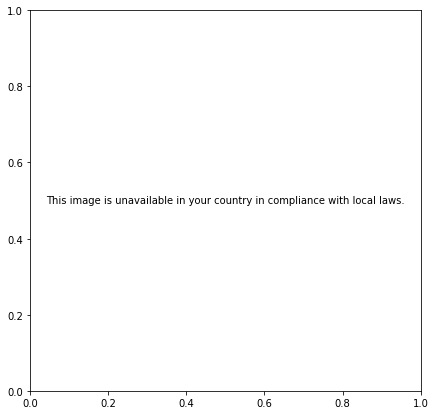


Изображение №2
Two black dogs are fighting over a toy
4/4 [==============================] - 0s 4ms/step


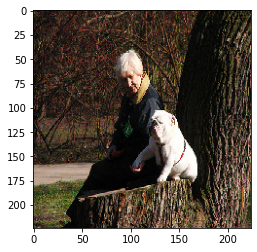

image_id: 2448210587_9fe7ea5f42.jpg
max_probability: 0.30309998989105225

Изображение №3
A cyclist riding on their front wheel on the asphalt .
4/4 [==============================] - 0s 3ms/step


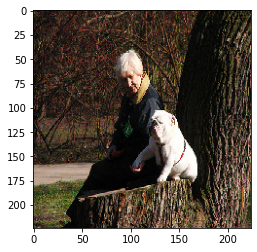

image_id: 2448210587_9fe7ea5f42.jpg
max_probability: 0.302700012922287

Изображение №4
A group of people walk through a shopping mall .
4/4 [==============================] - 0s 3ms/step


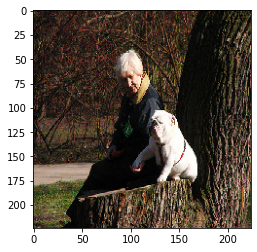

image_id: 2448210587_9fe7ea5f42.jpg
max_probability: 0.3005000054836273

Изображение №5
The man is performing a trick with an orange bicycle .
4/4 [==============================] - 0s 5ms/step


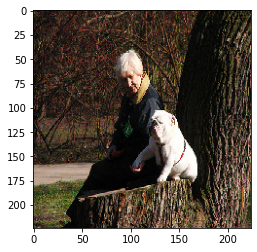

image_id: 2448210587_9fe7ea5f42.jpg
max_probability: 0.31450000405311584

Изображение №6
A group of people gather on the grass field and throw a pink hoop .
4/4 [==============================] - 0s 4ms/step


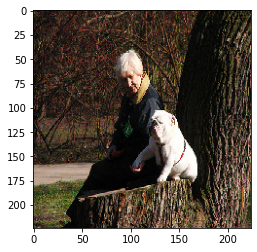

image_id: 2448210587_9fe7ea5f42.jpg
max_probability: 0.30550000071525574

Изображение №7
Three women are dressed in costumes while one holds an umbrella .
4/4 [==============================] - 0s 6ms/step


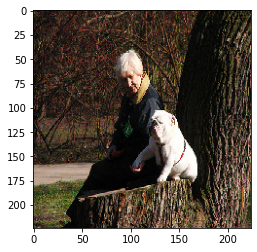

image_id: 2448210587_9fe7ea5f42.jpg
max_probability: 0.311599999666214

Изображение №8


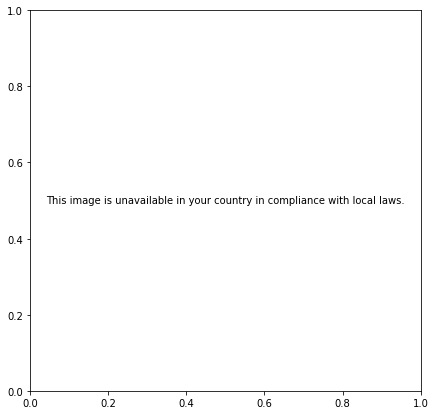


Изображение №9
People in a tent shelter near the bottom of stairs .
4/4 [==============================] - 0s 6ms/step


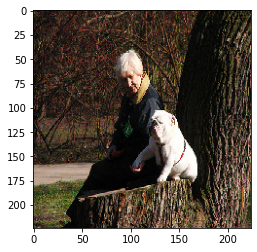

image_id: 2448210587_9fe7ea5f42.jpg
max_probability: 0.3034000098705292

Изображение №10


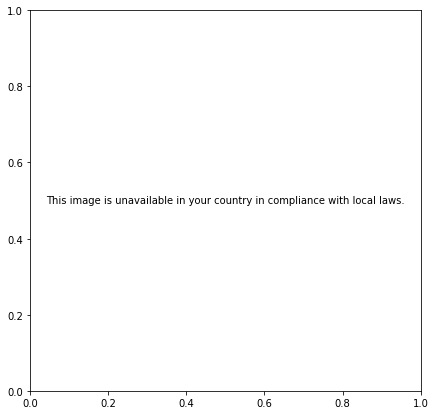

In [79]:
# протестируем на десяти случайных описаний из тестового датасета
df_sample = df_test.sample(10, random_state=23)
for i in range(df_sample.shape[0]):
  print(f'Изображение №{i+1}')
  text_to_image(df_sample['query_text'].iloc[i])
  print()

## 9. Заключение
Таким образом, в этом проекте мы:
- разобрали данные, их описательную характеристику;
- создали функции, которые преобразуют наши изображения и описания в векторы;
- создали модель, определяющую сходство описания и изображения.

Удалось применить нейронную сеть с несколькими слоями и параметрами. 

В целом, модель работает корректно по тем данным, которые у нас имеются.

Увеличение датасета может существенно улучшить результаты, а также можно подобрать более глубокие параметры для нейронной сети (в том случае, если позволяют ресурсы машины).